# Python notebook for hyperparameter and DR method selection using DynamicViz variance score (Figure 3)

https://doi.org/10.1101/2022.05.27.493785

In [1]:
import sys
import scanpy as sc
import scvelo as scv
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns#; sns.set()
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from scipy.stats import wilcoxon
from statannot import add_stat_annotation

from dynamicviz.dynamicviz import boot, viz, score, utils
import sklearn.manifold as skm

import trimap
import pacmap
import os
import shutil

In [2]:
# check versions

import sklearn
import umap
print(sklearn.__version__)
print(umap.__version__)
print(trimap.__version__)
print(pacmap.__version__)

1.0.2
0.5.2
1.1.2
0.5.4


# Figure 3A: Optimizing hyperparameters for visualization stability

See scg_results/hyperparameters

See scg_scripts/optimize_viz_hyperparams.py
- This script was used to generate the results that are processed in this section of the notebook.

**SVZ single-cell transcriptomic dataset (Buckley & Sun et al., 2022)**

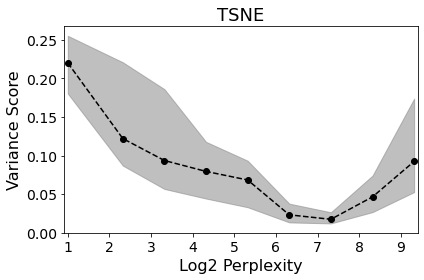

In [3]:
# t-SNE
dirpath = 'scg_results/hyperparameters'
best_save_dir = 'scg_results/best_hyperparams'
method = 'tsne'
hyperparam_tag = 'perplexity'
xlabel = "Perplexity"
xscale = 'log2' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

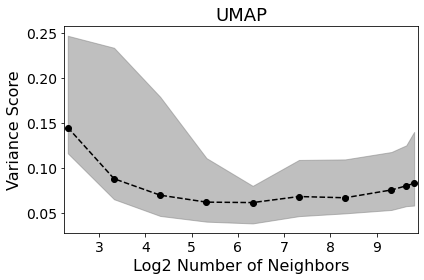

In [4]:
# UMAP
dirpath = 'scg_results/hyperparameters'
best_save_dir = 'scg_results/best_hyperparams'
method = 'umap'
hyperparam_tag = 'neighbors'
xlabel = "Number of Neighbors"
xscale = 'log2' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

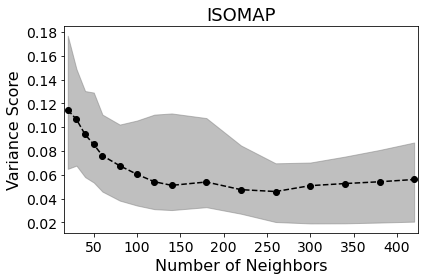

In [5]:
# IsoMap
dirpath = 'scg_results/hyperparameters'
best_save_dir = 'scg_results/best_hyperparams'
method = 'isomap'
hyperparam_tag = 'neighbors'
xlabel = "Number of Neighbors"
xscale = 'normal' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

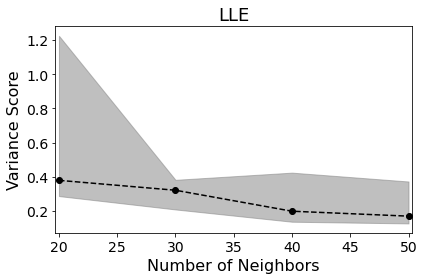

In [8]:
# LLE
dirpath = 'scg_results/hyperparameters'
best_save_dir = 'scg_results/best_hyperparams'
method = 'lle'
hyperparam_tag = 'neighbors'
xlabel = "Number of Neighbors"
xscale = 'normal' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

### Pancreas lineage dataset (Bastidas-Ponce et al., 2019)

- Corresponds to ED Figure 5 panels

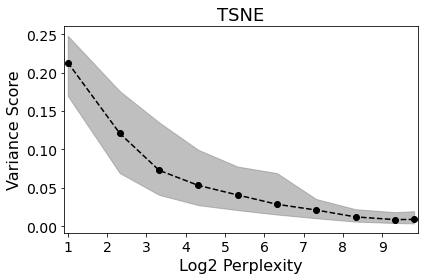

In [24]:
# t-SNE
dirpath = 'scg_results/hyperparameters/Pancreas'
best_save_dir = 'scg_results/best_hyperparams/Pancreas'
method = 'tsne'
hyperparam_tag = 'perplexity'
xlabel = "Perplexity"
xscale = 'log2' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/Pancreas"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

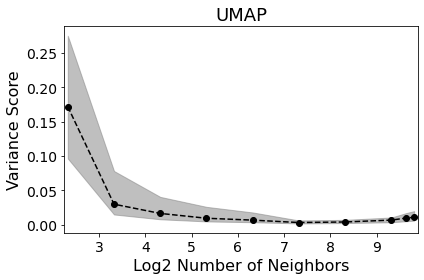

In [25]:
# UMAP
dirpath = 'scg_results/hyperparameters/Pancreas'
best_save_dir = 'scg_results/best_hyperparams/Pancreas'
method = 'umap'
hyperparam_tag = 'neighbors'
xlabel = "Number of Neighbors"
xscale = 'log2' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/Pancreas_"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

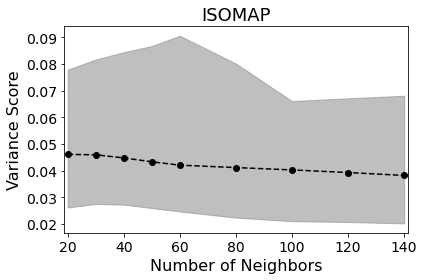

In [26]:
# IsoMap
dirpath = 'scg_results/hyperparameters/Pancreas'
best_save_dir = 'scg_results/best_hyperparams/Pancreas'
method = 'isomap'
hyperparam_tag = 'neighbors'
xlabel = "Number of Neighbors"
xscale = 'normal' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/Pancreas_"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

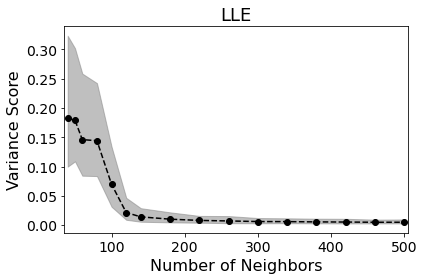

In [9]:
# LLE
dirpath = 'scg_results/hyperparameters/Pancreas'
best_save_dir = 'scg_results/best_hyperparams/Pancreas'
method = 'lle'
hyperparam_tag = 'neighbors'
xlabel = "Number of Neighbors"
xscale = 'normal' # normal or log2

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" in mfn]

hyperparams = []
variances = []
hyperparams_single = []
medians = []
uppers = []
lowers = []

for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1])
    # read in variance scores and append
    vscores = np.genfromtxt(os.path.join(dirpath,mfn))
    variances.append(vscores)
    hyperparams.append([hyperparam]*len(vscores))
    # append other info for plotting
    hyperparams_single.append(hyperparam)
    medians.append(np.median(vscores))
    uppers.append(np.percentile(vscores,97.5))
    lowers.append(np.percentile(vscores,2.5))

# save a copy of results files of lowest variance score
best_idx = medians.index(np.min(medians))
mfn = method_filenames[best_idx]
shutil.copyfile(os.path.join(dirpath,mfn), os.path.join(best_save_dir,mfn))
shutil.copyfile(os.path.join(dirpath,mfn.split('_variance')[0]+'.csv'),
                os.path.join(best_save_dir,mfn.split('_variance')[0]+'.csv'))
    
# process results
    
hyperparams = np.concatenate(hyperparams)
variances = np.concatenate(variances)

# sort values
medians = [x for _, x in sorted(zip(hyperparams_single, medians))]
uppers = [x for _, x in sorted(zip(hyperparams_single, uppers))]
lowers = [x for _, x in sorted(zip(hyperparams_single, lowers))]
hyperparams_single = list(sorted(hyperparams_single))

# Make lineplot
if xscale == 'normal':
    #sns.lineplot(x=hyperparams, y=variances, ci='sd')
    plt.plot(hyperparams_single, medians, 'ko--', linewidth=1.5)
    plt.fill_between(hyperparams_single, lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel(xlabel, fontsize=16)
    range_x = np.max(hyperparams_single)-np.min(hyperparams_single)
    plt.xlim(np.min(hyperparams_single)-0.01*range_x, np.max(hyperparams_single)+0.01*range_x)
else:
    #sns.lineplot(x=hyperparams, y=np.log2(variances), ci='sd', palette=['k'])
    plt.plot(np.log2(hyperparams_single), medians, 'ko--', linewidth=1.5)
    plt.fill_between(np.log2(hyperparams_single), lowers, uppers, color='0.5', alpha=0.5, interpolate=True)
    plt.xlabel("Log2 "+xlabel, fontsize=16)
    range_x = np.max(np.log2(hyperparams_single))-np.min(np.log2(hyperparams_single))
    plt.xlim(np.min(np.log2(hyperparams_single))-0.01*range_x, np.max(np.log2(hyperparams_single))+0.01*range_x)
plt.title(method.upper(), fontsize=18)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/Pancreas_"+method+"_"+hyperparam_tag+"_hyperparameters.png", dpi=500)
plt.show()

### Showcasing some SVZ plots at different hyperparameter values

In [117]:
# t-SNE
dirpath = 'scg_results/hyperparameters'
method = 'tsne'
hyperparam_tag = 'perplexity'
hyperparams = [2, 160, 320, 640]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='celltype', width=6, height=4)

In [5]:
# t-SNE
dirpath = 'scg_results/hyperparameters'
method = 'tsne'
hyperparam_tag = 'perplexity'
hyperparams = [5, 10, 20, 40, 80, 320, 640]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='celltype', width=3, height=3, show_legend=False)

In [6]:
# UMAP
dirpath = 'scg_results/hyperparameters'
method = 'umap'
hyperparam_tag = 'neighbors'
hyperparams = [10,20,40,80,160,320,640,800,900]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='celltype', width=3, height=3, show_legend=False)

In [13]:
# ISOMAP
dirpath = 'scg_results/hyperparameters'
method = 'isomap'
hyperparam_tag = 'neighbors'
hyperparams = [20,30,40,50,60,80,100,120,140]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='celltype', width=3, height=3, show_legend=False)

In [6]:
# t-SNE
dirpath = 'scg_results/hyperparameters/Pancreas'
method = 'tsne'
hyperparam_tag = 'perplexity'
hyperparams = [2, 160, 320, 640]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/Pancreas_"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='clusters', width=6, height=4)

In [8]:
# LLE
dirpath = 'scg_results/hyperparameters/Pancreas'
method = 'lle'
hyperparam_tag = 'neighbors'
hyperparams = [40, 500]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/Pancreas_"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='clusters', width=6, height=4)

In [7]:
# LLE
dirpath = 'scg_results/hyperparameters/Pancreas'
method = 'lle'
hyperparam_tag = 'neighbors'
hyperparams = [50,60,80,100,120,140,300]

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam in hyperparams:
        viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
                   save="figures/Figure3/Pancreas_"+method+"_"+hyperparam_tag+"_"+str(hyperparam)+"_static.png",
                  dpi=500, alpha=0.01, label='clusters', width=3, height=3, show_legend=False)

# Figure 3B: Comparing optimized visualization methods

### SVZ dataset

In [28]:
# Compare best optimized methods
dirpath = 'scg_results/best_hyperparams'
methods = ['lle', 'tsne', 'umap', 'pacmap', 'mds', 'trimap', 'isomap']

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [mfn for mfn in filenames if "variance" in mfn]

method_names = []
variances = []

for mfn in method_filenames:
    # parse method name
    method = mfn.split('_')[3]
    if method in methods:
        # read in variance scores and append
        vscores = np.genfromtxt(os.path.join(dirpath,mfn))
        variances.append(vscores)
        # append method name
        method_names.append([method.upper()]*len(vscores))
        
# Make long form df
method_names = np.concatenate(method_names)
variances = np.concatenate(variances)
df = pd.DataFrame([])
df["Method"] = method_names
df["Variance Score"] = variances

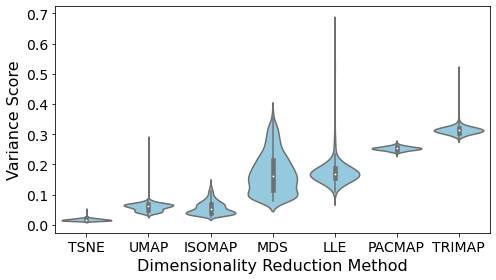

In [10]:
plt.figure(figsize=(7,4))
sns.violinplot(data=df, x="Method", y="Variance Score", width=0.8, scale='count',
              order=['TSNE', 'UMAP', 'ISOMAP', 'MDS', 'LLE', 'PACMAP', 'TRIMAP'],
              color='skyblue')
plt.ylabel("Variance Score", fontsize=16)
plt.xlabel("Dimensionality Reduction Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/DR_comparison.png", dpi=500)
plt.show()

### Pancreas dataset
- corresponds to ED Figure 5 panels

In [29]:
# Compare best optimized methods
dirpath = 'scg_results/best_hyperparams/Pancreas'
methods = ['lle', 'tsne', 'umap', 'pacmap', 'mds', 'trimap', 'isomap']

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [mfn for mfn in filenames if "variance" in mfn]

method_names = []
variances = []

for mfn in method_filenames:
    # parse method name
    method = mfn.split('_')[3]
    if method in methods:
        # read in variance scores and append
        vscores = np.genfromtxt(os.path.join(dirpath,mfn))
        variances.append(vscores)
        # append method name
        method_names.append([method.upper()]*len(vscores))
        
# Make long form df
method_names = np.concatenate(method_names)
variances = np.concatenate(variances)
df = pd.DataFrame([])
df["Method"] = method_names
df["Variance Score"] = variances

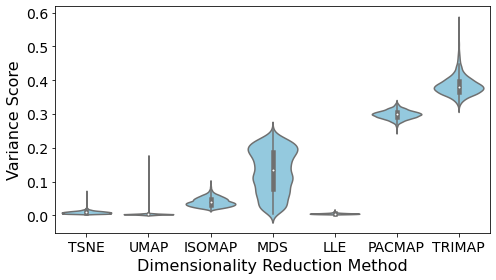

In [30]:
plt.figure(figsize=(7,4))
sns.violinplot(data=df, x="Method", y="Variance Score", width=0.8, scale='count',
              order=['TSNE', 'UMAP', 'ISOMAP', 'MDS', 'LLE', 'PACMAP', 'TRIMAP'],
              color='skyblue')
plt.ylabel("Variance Score", fontsize=16)
plt.xlabel("Dimensionality Reduction Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/Pancreas_DR_comparison.png", dpi=500)
plt.show()

### Plotting optimized versions of each DR

In [11]:
dirpath = 'scg_results/best_hyperparams'

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [mfn for mfn in filenames if "variance" not in mfn]


for mfn in method_filenames:
    # parse method name
    if ('mds' not in mfn) and ('pca' not in mfn):
        method = mfn.split('_')[3]
        hyperparam = mfn.split('_')[4].split(".")[0]
    else:
        method = mfn.split('_')[3].split(".")[0]
        hyperparam = ''
    
    viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
               save="figures/Figure3/"+method+"_"+hyperparam+"_static.png",
              dpi=500, alpha=0.01, label='celltype', width=6, height=4)

In [11]:
dirpath = 'scg_results/best_hyperparams/Pancreas'

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [mfn for mfn in filenames if "variance" not in mfn]


for mfn in method_filenames:
    # parse method name
    if ('mds' not in mfn) and ('pca' not in mfn):
        method = mfn.split('_')[3]
        hyperparam = mfn.split('_')[4].split(".")[0]
    else:
        method = mfn.split('_')[3].split(".")[0]
        hyperparam = ''
    
    viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
               save="figures/Figure3/Pancreas_"+method+"_"+hyperparam+"_static.png",
              dpi=500, alpha=0.01, label='clusters', width=6, height=4)

### Plotting comparative versions

In [5]:
dirpath = 'scg_results/hyperparameters'

method_filenames = ["SVZ_n1000_B100_isomap_neighbors20.csv", "SVZ_n1000_B100_lle_neighbors20.csv",
                    "SVZ_n1000_B100_pacmap_neighbors38.csv", "SVZ_n1000_B100_trimap_neighbors2.csv",
                    "SVZ_n1000_B100_umap_neighbors5.csv"]


for mfn in method_filenames:
    
    # parse method name
    if ('mds' not in mfn) and ('pca' not in mfn):
        method = mfn.split('_')[3]
        hyperparam = mfn.split('_')[4].split(".")[0]
    else:
        method = mfn.split('_')[3].split(".")[0]
        hyperparam = ''
    
    viz.stacked(pd.read_csv(os.path.join(dirpath,mfn)),
               save="figures/Figure3/"+method+"_"+hyperparam+"_static.png",
              dpi=500, alpha=0.01, label='celltype', width=6, height=4)

# Supplementary: Comparison with EMBEDR

In [2]:
import EMBEDR
print(EMBEDR.__version__)
from EMBEDR import EMBEDR, EMBEDR_sweep

2.1.1


In [73]:
# read in SVZ 1000-cell dataset
SVZ_X = pd.read_csv("sc_data/mouse_svz_aging_clock/svz_data.csv")
SVZ_X = SVZ_X.values
SVZ_X = SVZ_X/SVZ_X.sum(axis=1)[:,np.newaxis] # row normalize
SVZ_X = np.log1p(SVZ_X*10000) # scale up and take log1p

SVZ_y = np.genfromtxt("SVZ_y.txt", dtype=str)
SVZ_age = np.genfromtxt("SVZ_age.txt")
SVZ_Y = pd.DataFrame(np.vstack((SVZ_y,SVZ_age)).T, columns=["celltype", "age"])

pca = PCA(n_components=50)
SVZ_X = pca.fit_transform(SVZ_X)

In [74]:
sweepObj = EMBEDR_sweep(project_name="EMBEDR_SVZ_TSNE",
                        project_dir="./",
                        DRA='tsne',
                        n_jobs=8,  ## Set to -1 to use all available processors.
                        verbose=3,  ## Set to 0 to suppress output.
                        n_data_embed=5,
                        n_null_embed=1,
                        sweep_type='perplexity',
                        sweep_values=[2,5,10,20,40,80,160,320,640])
sweepObj.fit(SVZ_X)
#sweepObj.plot_embedding(embed_2_show=1, param_2_plot=250)


Initializing EMBEDR hyperparameter sweep!
Array of hyperparameter values provided, ignoring input values for `n_sweep_values`, `min_sweep_value, and `max_sweep_value`.
Hyperparameter values specified absolutely!

Sweeping over 9 values of the 'perplexity' parameter!

Fitting 'perplexity' sweep!
All hyperparameter values provided absolutely!

Fitting data with 'perplexity' = 640 (1 / 9)


	EMBEDR Class v2.1.1

	Intermediate results for the EMBEDR_SVZ_TSNE project will be cached in ./!
	kNN algorithm is auto
	Affinity type is fixed_entropy_gauss
	Dim.Red. Algorithm is tsne
	n_components = 2
	n_data_embed = 5
	n_null_embed = 1

Initializing kNN index...
Error loading kNN graph: no kNN graphs have yet been made for this data and/or seed!

Fitting kNN graph to data with k=999 neighbors...
---> Finding 999 nearest neighbors using an approximate search and the euclidean metric...
---> Time Elapsed: 0.32 seconds!
Caching Data_kNN_0000.knn to file!

Initializing affinity matrix...
A kNN graph 

Itr   50, DKL 0.3858,	50 iterations in 0.2892 sec
Itr  100, DKL 0.3858,	50 iterations in 0.2657 sec
Itr  150, DKL 0.3858,	50 iterations in 0.2470 sec
Itr  200, DKL 0.3858,	50 iterations in 0.2559 sec
Itr  250, DKL 0.3858,	50 iterations in 0.2378 sec
---> Time Elapsed: 1.3 seconds!
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 0.3858,	50 iterations in 0.2387 sec
Itr  100, DKL 0.1557,	50 iterations in 0.2362 sec
Itr  150, DKL 0.0992,	50 iterations in 0.2362 sec
Itr  200, DKL 0.0991,	50 iterations in 0.2432 sec
Itr  250, DKL 0.0991,	50 iterations in 0.2407 sec
---> Time Elapsed: 1.3 seconds!
Optimization interrupted by callback
Calculating D_KL as EES!
Caching Null_tSNE_Embed_0000.emb to file!

Calulating EES p-Values!
Returning summary p-Values using averaging method!

Fitting data with 'perplexity' = 320 (2 / 9)


	EMBEDR Class v2.1.1

	Intermediate results for the EMBEDR_SVZ_TSNE project will be cached in ./!
	kNN algorith

---> Time Elapsed: 0.22 seconds!
Caching Null_AffMat_0002.aff to file!

Initializing t-SNE Embedding...

Initialized EMBEDR.tSNE_Embed object!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.

Initializing affinity matrix...
A kNN graph has been input!
Searching for matching affinity matrix in Null cache...
A kNN graph has been input!
---> Calculating fixed-entropy Gaussian affinity matrix!
---> Time Elapsed: 0.22 seconds!
Caching Null_AffMat_0003.aff to file!
Looking for matching t-SNE embeddings in the 'Null' cache.

Fitting embedding 1/1 (1 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.
---> Fitting t-SNE for up to 250 iterations with exaggeration = 12.0 and learning rate = 200.0.
Itr   50, DKL 1.0260,	50 iterations in 0.2570 sec
Itr  100, DKL 1.0260,	50 iterations in 0.250

---> Time Elapsed: 0.11 seconds!
Caching Null_AffMat_0004.aff to file!

Initializing t-SNE Embedding...

Initialized EMBEDR.tSNE_Embed object!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.

Initializing affinity matrix...
A kNN graph has been input!
Searching for matching affinity matrix in Null cache...
A kNN graph has been input!
---> Calculating fixed-entropy Gaussian affinity matrix!
---> Time Elapsed: 0.11 seconds!
Caching Null_AffMat_0005.aff to file!
Looking for matching t-SNE embeddings in the 'Null' cache.

Fitting embedding 1/1 (1 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.
---> Fitting t-SNE for up to 250 iterations with exaggeration = 12.0 and learning rate = 200.0.
Itr   50, DKL 1.6868,	50 iterations in 0.2679 sec
Itr  100, DKL 1.6868,	50 iterations in 0.236

Caching Data_tSNE_Embed_0003.emb to file!

Generating null 1 / 1

Initializing kNN index...
Searching for matching kNN graph in Null cache...
kNN graph at EMBEDR_SVZ_TSNE/98a8787949b20522226720c5ecbbbcbf/Null_kNN_0000.knn passed all checks!
Attempting to load kNN graph...
Loading Annoy index from ./EMBEDR_SVZ_TSNE/98a8787949b20522226720c5ecbbbcbf/Null_kNN_0000.ann
kNN graph loaded!  Checking shape ... Too many neighbors, clipping kNN graph...

Initializing affinity matrix...
A kNN graph has been input!
Searching for matching affinity matrix in Null cache...
A kNN graph has been input!
---> Calculating fixed-entropy Gaussian affinity matrix!
---> Time Elapsed: 0.056 seconds!
Caching Null_AffMat_0006.aff to file!

Initializing t-SNE Embedding...

Initialized EMBEDR.tSNE_Embed object!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.

Initializing affinity matrix...
A kNN graph has been input!
Searching for matching affinity matrix in Nu

Itr   50, DKL 2.5526,	50 iterations in 0.2553 sec
---> Time Elapsed: 0.52 seconds!
Optimization interrupted by callback
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 0.8113,	50 iterations in 0.2316 sec
Itr  100, DKL 0.6934,	50 iterations in 0.2316 sec
Itr  150, DKL 0.6554,	50 iterations in 0.2216 sec
Itr  200, DKL 0.6400,	50 iterations in 0.2210 sec
Itr  250, DKL 0.6338,	50 iterations in 0.2197 sec
Itr  300, DKL 0.6305,	50 iterations in 0.2442 sec
Itr  350, DKL 0.6279,	50 iterations in 0.3253 sec
Itr  400, DKL 0.6261,	50 iterations in 0.3241 sec
Itr  450, DKL 0.6240,	50 iterations in 0.3270 sec
---> Time Elapsed: 2.4 seconds!
Optimization interrupted by callback
Calculating D_KL as EES!
Caching Data_tSNE_Embed_0004.emb to file!

Generating null 1 / 1

Initializing kNN index...
Searching for matching kNN graph in Null cache...
kNN graph at EMBEDR_SVZ_TSNE/98a8787949b20522226720c5ecbbbcbf/Null_kNN_0000.knn passed all checks!

Itr   50, DKL 1.1698,	50 iterations in 0.2203 sec
Itr  100, DKL 0.9929,	50 iterations in 0.2178 sec
Itr  150, DKL 0.9320,	50 iterations in 0.2372 sec
Itr  200, DKL 0.9107,	50 iterations in 0.3591 sec
Itr  250, DKL 0.9002,	50 iterations in 0.4224 sec
Itr  300, DKL 0.8902,	50 iterations in 0.4549 sec
---> Time Elapsed: 2.1 seconds!
Optimization interrupted by callback

Fitting embedding 5/5 (5 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.
---> Fitting t-SNE for up to 250 iterations with exaggeration = 12.0 and learning rate = 200.0.
Itr   50, DKL 3.0010,	50 iterations in 0.2201 sec
---> Time Elapsed: 0.45 seconds!
Optimization interrupted by callback
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 1.1734,	50 iterations in 0.2173 sec
Itr  100, DKL 0.9982,	50 iterations 

Itr  450, DKL 1.1298,	50 iterations in 1.2120 sec
---> Time Elapsed: 6.2 seconds!
Optimization interrupted by callback

Fitting embedding 4/5 (5 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.
---> Fitting t-SNE for up to 250 iterations with exaggeration = 12.0 and learning rate = 200.0.
Itr   50, DKL 3.7566,	50 iterations in 0.2196 sec
---> Time Elapsed: 0.44 seconds!
Optimization interrupted by callback
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 1.5365,	50 iterations in 0.2241 sec
Itr  100, DKL 1.2818,	50 iterations in 0.2225 sec
Itr  150, DKL 1.1981,	50 iterations in 0.3208 sec
Itr  200, DKL 1.1643,	50 iterations in 0.4509 sec
Itr  250, DKL 1.1521,	50 iterations in 0.5176 sec
Itr  300, DKL 1.1405,	50 iterations in 0.5402 sec
Itr  350, DKL 1.1315,	50 iterations 

Itr   50, DKL 4.4150,	50 iterations in 0.2207 sec
---> Time Elapsed: 0.43 seconds!
Optimization interrupted by callback
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 1.8544,	50 iterations in 0.2124 sec
Itr  100, DKL 1.5083,	50 iterations in 0.2425 sec
Itr  150, DKL 1.3928,	50 iterations in 0.4750 sec
Itr  200, DKL 1.3455,	50 iterations in 0.7880 sec
Itr  250, DKL 1.3189,	50 iterations in 1.0669 sec
Itr  300, DKL 1.2967,	50 iterations in 0.7844 sec
Itr  350, DKL 1.2867,	50 iterations in 0.8921 sec
---> Time Elapsed: 4.9 seconds!
Optimization interrupted by callback

Fitting embedding 4/5 (5 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.
---> Fitting t-SNE for up to 250 iterations with exaggeration = 12.0 and learning rate = 200.0.
Itr   50, DKL 4.6279,	50 iterations 

Itr   50, DKL 5.1433,	50 iterations in 0.2621 sec
---> Time Elapsed: 0.48 seconds!
Optimization interrupted by callback
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 2.1637,	50 iterations in 0.2124 sec
Itr  100, DKL 1.7160,	50 iterations in 0.3181 sec
Itr  150, DKL 1.5609,	50 iterations in 0.5131 sec
Itr  200, DKL 1.4788,	50 iterations in 1.0016 sec
Itr  250, DKL 1.4347,	50 iterations in 0.7970 sec
Itr  300, DKL 1.4052,	50 iterations in 0.9559 sec
Itr  350, DKL 1.3864,	50 iterations in 1.3248 sec
Itr  400, DKL 1.3672,	50 iterations in 1.3763 sec
Itr  450, DKL 1.3533,	50 iterations in 1.5047 sec
---> Time Elapsed: 8.6 seconds!
Optimization interrupted by callback

Fitting embedding 3/5 (5 total requested).

Initialized EMBEDR.tSNE_Embed object!

Generating 2-dimensional embedding with t-SNE!
Data to be fit (`X`) are an affinity matrix!
Generating random initial embedding with same size as X.
---> Fitting t-SNE for up to 250

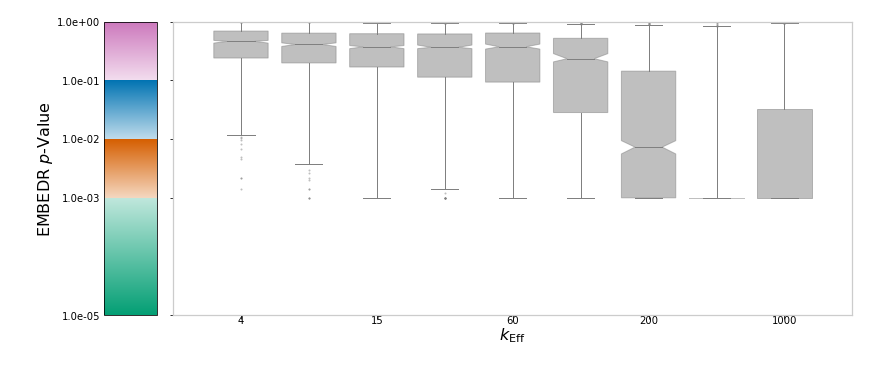

In [76]:
sweepObj.sweep_boxplot()
plt.savefig("figures/Extended/EMBEDR_perplexity_keff_plot.png", dpi=500)

In [77]:
sweepObj.fit_samplewise_optimal()

Setting optimal perplexity using normal fits.


	EMBEDR Class v2.1.1

	Intermediate results for the EMBEDR_SVZ_TSNE project will be cached in ./!
	kNN algorithm is auto
	Affinity type is fixed_entropy_gauss
	Dim.Red. Algorithm is tsne
	n_components = 2
	n_data_embed = 5
	n_null_embed = 1

Initializing kNN index...
Searching for matching kNN graph in Data cache...
kNN graph at EMBEDR_SVZ_TSNE/98a8787949b20522226720c5ecbbbcbf/Data_kNN_0000.knn passed all checks!
Attempting to load kNN graph...
Loading Annoy index from ./EMBEDR_SVZ_TSNE/98a8787949b20522226720c5ecbbbcbf/Data_kNN_0000.ann
kNN graph loaded!  Checking shape ... ... shape is correct!

Initializing affinity matrix...
A kNN graph has been input!
Searching for matching affinity matrix in Data cache...
A kNN graph has been input!
---> Calculating fixed-entropy Gaussian affinity matrix!
---> Time Elapsed: 0.21 seconds!
Caching Data_AffMat_0018.aff to file!

Initializing t-SNE Embedding...

Initialized EMBEDR.tSNE_Embed object!
Data

Itr   50, DKL 1.2799,	50 iterations in 0.2495 sec
Itr  100, DKL 1.2799,	50 iterations in 0.2461 sec
Itr  150, DKL 1.2799,	50 iterations in 0.2386 sec
Itr  200, DKL 1.2799,	50 iterations in 0.2394 sec
Itr  250, DKL 1.2799,	50 iterations in 0.2425 sec
---> Time Elapsed: 1.2 seconds!
---> Fitting t-SNE for up to 1000 iterations with exaggeration = 1.0 and learning rate = 200.0.
Itr   50, DKL 1.2799,	50 iterations in 0.2325 sec
Itr  100, DKL 0.4293,	50 iterations in 0.2425 sec
Itr  150, DKL 0.4168,	50 iterations in 0.2409 sec
Itr  200, DKL 0.4135,	50 iterations in 0.2382 sec
Itr  250, DKL 0.4125,	50 iterations in 0.2404 sec
---> Time Elapsed: 1.4 seconds!
Optimization interrupted by callback
Calculating D_KL as EES!
Caching Null_tSNE_Embed_0009.emb to file!

Calulating EES p-Values!
Returning summary p-Values using averaging method!


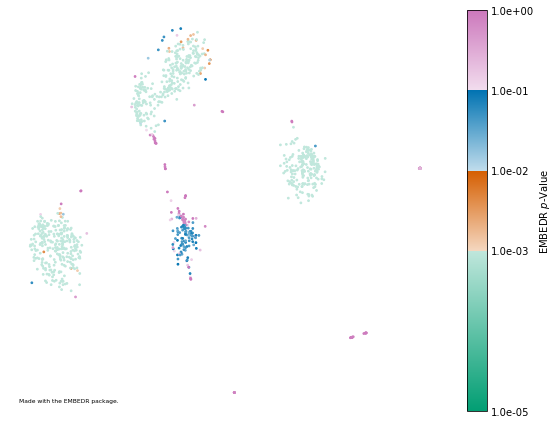

In [78]:
sweepObj.plot_embedding()
plt.savefig("figures/Extended/EMBEDR_samplewise_optimal_tSNE.png", dpi=500)

In [86]:
# find optimal perplexity

mean_pvalue = []
for key in sweepObj.pValues.keys():
    mean_pvalue.append(np.mean(sweepObj.pValues[key]))
    
best_perplexity = list(sweepObj.pValues.keys())[np.argmin(mean_pvalue)]
print(best_perplexity)

best_embedding = sweepObj.embeddings[best_perplexity]
best_embedding = best_embedding.mean(axis=0)

320


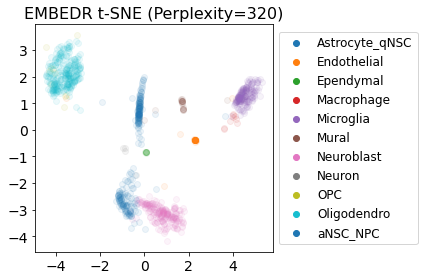

In [94]:
for ct in np.unique(SVZ_y):
    plt.scatter(best_embedding[SVZ_y==ct,0], best_embedding[SVZ_y==ct,1],
                      alpha=0.08, label=ct)
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("EMBEDR t-SNE (Perplexity="+str(best_perplexity)+")", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure3/EMBEDR_optperp"+str(best_perplexity)+"_TSNE.png", dpi=500, width=6, height=4)
plt.show()

In [114]:
# retrieve DynamicViz stacked overlay

dirpath = 'scg_results/hyperparameters'
method = 'tsne'
hyperparam_tag = 'perplexity'

#-----------------------------------------------------------------

filenames = os.listdir(dirpath)
method_filenames = [fn for fn in filenames if "_"+method+"_" in fn]
method_filenames = [mfn for mfn in method_filenames if "variance" not in mfn]
    
for mfn in method_filenames:
    # parse hyperparameter value
    hyperparam = float(mfn.split('_')[4].split(hyperparam_tag)[1].split(".")[0])
    if hyperparam == 160:
        df = pd.read_csv(os.path.join(dirpath,mfn))
    elif hyperparam == 320:
        df320 = pd.read_csv(os.path.join(dirpath,mfn))

In [116]:
# Compare against EMBEDR optimal embedding

from sklearn.metrics import silhouette_score, silhouette_samples

score_dv = silhouette_score(df[df['bootstrap_number']<10][["x1", "x2"]], df[df['bootstrap_number']<10]["celltype"])
score_dv320 = silhouette_score(df320[df320['bootstrap_number']<10][["x1", "x2"]], df320[df320['bootstrap_number']<10]["celltype"])
score_embedr_160 = silhouette_score(embedding160, SVZ_y)
score_embedr_best = silhouette_score(best_embedding, SVZ_y)
score_embedr_opt = silhouette_score(opt_embedding, SVZ_y)

print([score_dv, score_dv320, score_embedr_160, score_embedr_best, score_embedr_opt])

[0.19697562449187989, 0.12469131306365346, 0.12134698451421089, 0.44889522197425313, 0.4583229441947843]


DynamicViz
 Perplexity = 160
 v.s. EMBEDR
 Perplexity = 320
: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.092e-130 U_stat=7.192e+07


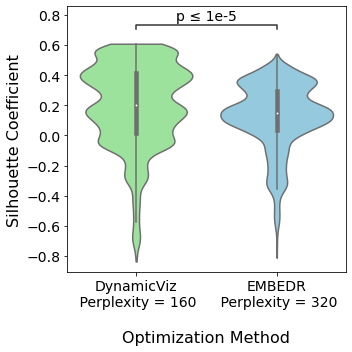

In [130]:
# Comparison on Stacked overlays (EMBEDR vs DynamicViz)
    # Silhouette (clustering)

from sklearn.metrics import silhouette_score, silhouette_samples

score_dv160 = silhouette_samples(df[df['bootstrap_number']<10][["x1", "x2"]], df[df['bootstrap_number']<10]["celltype"])
score_dv320 = silhouette_samples(df320[df320['bootstrap_number']<10][["x1", "x2"]], df320[df320['bootstrap_number']<10]["celltype"])


# violin plot

dfv = pd.DataFrame()
dfv['value'] = np.concatenate((score_dv160, score_dv320))
dfv['label'] = ["DynamicViz\n Perplexity = 160\n"]*len(score_dv160) + ["EMBEDR\n Perplexity = 320\n"]*len(score_dv160)

# make plot
plt.figure(figsize=(5,5))
ax = sns.violinplot(x='label', y='value', data=dfv, palette=['lightgreen','skyblue'], scale='width', cut=0)
add_stat_annotation(ax, x="label", y='value', data=dfv,
                    box_pairs=[("DynamicViz\n Perplexity = 160\n", "EMBEDR\n Perplexity = 320\n")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("Silhouette Coefficient", fontsize=16)
ax.set_xlabel('Optimization Method', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Extended/EMBEDR_silhouette_comparison.png", dpi=500, bbox_inches='tight')
plt.show()

0.5937247157280516
0.5820312850136403
DynamicViz
 Perplexity = 160
 v.s. EMBEDR
 Perplexity = 320
: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.993e-27 U_stat=6.554e+07


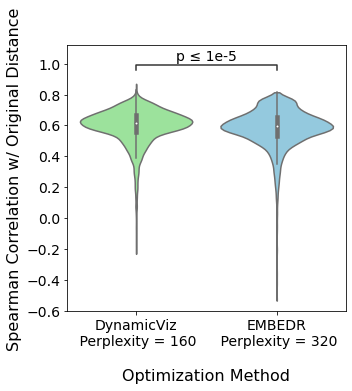

In [129]:
# Comparison on Stacked overlays (EMBEDR vs DynamicViz)
    # Spearman correlation

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import pairwise_distances

# for first 10 bootstraps
score_dv160 = []
score_dv320 = []

for b in np.arange(-1,10,1):
    dv160_dist = pairwise_distances(df[df['bootstrap_number']==b][["x1", "x2"]])
    dv320_dist = pairwise_distances(df320[df320['bootstrap_number']==b][["x1", "x2"]])
    orig_dist = pairwise_distances(SVZ_X[df320[df320['bootstrap_number']==b]["original_index"],:])

    for i in range(dv160_dist.shape[0]):
        score_dv160.append(spearmanr(dv160_dist[i,:],orig_dist[i,:])[0])
        score_dv320.append(spearmanr(dv320_dist[i,:],orig_dist[i,:])[0])

    
print(np.mean(score_dv160))
print(np.mean(score_dv320))
    
# violin plot

dfv = pd.DataFrame()
dfv['value'] = np.concatenate((score_dv160, score_dv320))
dfv['label'] = ["DynamicViz\n Perplexity = 160\n"]*len(score_dv160) + ["EMBEDR\n Perplexity = 320\n"]*len(score_dv160)

# make plot
plt.figure(figsize=(5,5))
ax = sns.violinplot(x='label', y='value', data=dfv, palette=['lightgreen','skyblue'], scale='width', cut=0)
add_stat_annotation(ax, x="label", y='value', data=dfv,
                    box_pairs=[("DynamicViz\n Perplexity = 160\n", "EMBEDR\n Perplexity = 320\n")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("Spearman Correlation w/ Original Distance", fontsize=16)
ax.set_xlabel('Optimization Method', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Extended/EMBEDR_spearman_comparison.png", dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist

dv_dist

score_dv = spearmanr(df[df['bootstrap_number']==-1][["x1", "x2"]], df[df['bootstrap_number']==-1]["celltype"])
score_embedr_160 = silhouette_score(embedding160, SVZ_y)
score_embedr_best = spearmanr(best_embedding, SVZ_y)
score_embedr_opt = spearmanr(opt_embedding, SVZ_y)

print([score_dv, score_embedr_best, score_embedr_opt])